# attempt to detect ticked/unticked and circled/not-circled images using openCV

In [ ]:
import importlib
import main
import os
importlib.reload(main)
from main import *
folder_list = [
    "dataset/images_test",
    "dataset/circled_no",
    "dataset/circled_yes",
    "dataset/unticked",
    "dataset/ticked",
    
]


def list_files_in_folder(folder_path, ext=None):
    """
    Returns a list of file names in the given folder, optionally filtering by extension.
    
    Parameters:
        folder_path (str): The path to the folder.
        ext (str, optional): The file extension to filter by (e.g., 'png'). Defaults to None.
        
    Returns:
        list: A list of file names matching the extension.
    """
    try:
        # List all files in the directory
        files = [
            f for f in os.listdir(folder_path)
            if os.path.isfile(os.path.join(folder_path, f))
        ]
        
        if ext is not None:
            # Normalize the extension to lowercase
            ext = ext.lower()
            # Filter files by extension (case-insensitive)
            files = [
                f for f in files
                if os.path.splitext(f)[1].lower() == f'.{ext}'
            ]
        
        return files
    
    except FileNotFoundError:
        print(f"The folder '{folder_path}' does not exist.")
        return []
    except PermissionError:
        print(f"Permission denied to access '{folder_path}'.")
        return []
    



threshold = 60  # Set your desired threshold

folder_list = [
    "dataset/images_test",
    "dataset/circled_no",
    "dataset/circled_yes",
    "dataset/unticked",
    "dataset/ticked",
    
]
for folder in folder_list:
    image_paths = list_files_in_folder(folder,ext="PNG")

    print(folder)
    for file_name in image_paths:
        full_file_path = os.path.join(folder, file_name)

        filename = full_file_path.split("/")[-1]
        name = filename.split(".")[0]
        unique_strings = [
        "no1_93",
        "no1_86",
        "yes1_2",
        "no1_96",
        "no1_97",
        "yes1_79",
        "no1_27",
        "no1_2",
        "no4",
        "no1_71",
        "yes1_60",
        "no1_22"
    ]

        # if name  in unique_strings:
        if name  in unique_strings or 1:
        # break   

            result_payload = process_image(full_file_path, threshold=threshold, show_plots=False)
            LOGGER.info(result_payload)



            # Save the resulting images with green or red text
            output_directory = 'results'
            file_name_prefix = os.path.splitext(os.path.basename(filename))[0]  # Use the original file name as prefix
            image = cv2.imread(full_file_path)
            annotated_image_path = annotate_image_openCV(
                image=image,
                result_payload=result_payload,
                output_path=output_directory,
                file_name_prefix=file_name_prefix,
        )

        

In [3]:
# epsilon_values = [0.01, 0.02, 0.03, 0.05]

# for epsilon_multiplier in epsilon_values:
#     print(f"\nTesting with epsilon_multiplier = {epsilon_multiplier}")
#     tick_detected, detection_info = detect_checkbox_with_tick(
#         gray,
#         area_threshold=100,
#         epsilon_multiplier=epsilon_multiplier,
#         debug=True,
#         show_plots=True
#     )

In [4]:
# param_ranges = {
#     'clahe_clip_limits': [1.0, 1.5, 2.0],
#     'tile_grid_sizes': [(4, 4), (8, 8)],
#     'block_sizes': [15, 21, 31],  # Must be odd numbers
#     'C_values': [2, 3, 5],
#     'area_thresholds': [50, 100, 200]
# }
# full_file_path = "dataset/images_test/no1_93.PNG"
# explore_detection_parameters(full_file_path, param_ranges)

# attempt to use a CNN model and identity detect ticked/unticked and circled/not-circled images

## training the model

INFO:__main__:Loading images from dataset
INFO:__main__:Folder path is /Users/brunoviola/WORK/detect_yes_no_answers/dataset/
INFO:__main__:Processing label: .DS_Store
INFO:__main__:Label '.DS_Store' folder is /Users/brunoviola/WORK/detect_yes_no_answers/dataset/.DS_Store
INFO:__main__:Processing label: ticked
INFO:__main__:Label 'ticked' folder is /Users/brunoviola/WORK/detect_yes_no_answers/dataset/ticked
INFO:__main__:Processing label: circled_yes
INFO:__main__:Label 'circled_yes' folder is /Users/brunoviola/WORK/detect_yes_no_answers/dataset/circled_yes
INFO:__main__:Processing label: images_test
INFO:__main__:Processing label: circled_no
INFO:__main__:Label 'circled_no' folder is /Users/brunoviola/WORK/detect_yes_no_answers/dataset/circled_no
INFO:__main__:Processing label: unticked
INFO:__main__:Label 'unticked' folder is /Users/brunoviola/WORK/detect_yes_no_answers/dataset/unticked
INFO:__main__:Labeling images
INFO:__main__:Splitting data into training, validation, and testing
I


Number of images per label in the entire dataset:
ticked (0): 335 images
unticked (1): 327 images
circled_yes (2): 306 images
circled_no (3): 338 images

Number of images per label in the training set:
ticked (0): 246 images
unticked (1): 221 images
circled_yes (2): 218 images
circled_no (3): 254 images

Number of images per label in the validation set:
ticked (0): 22 images
unticked (1): 34 images
circled_yes (2): 24 images
circled_no (3): 25 images

Number of images per label in the testing set:
ticked (0): 67 images
unticked (1): 72 images
circled_yes (2): 64 images
circled_no (3): 59 images
Epoch 1/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 6s 168ms/step - accuracy: 0.2426 - loss: 1.6728 - val_accuracy: 0.2095 - val_loss: 1.3755 - learning_rate: 0.0010
Epoch 2/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 6s 199ms/step - accuracy: 0.4200 - loss: 1.2596 - val_accuracy: 0.6381 - val_loss: 0.9516 - learning_rate: 0.0010
Epoch 3/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 175ms/step - accuracy: 0.6929 - loss: 0.8606 - va

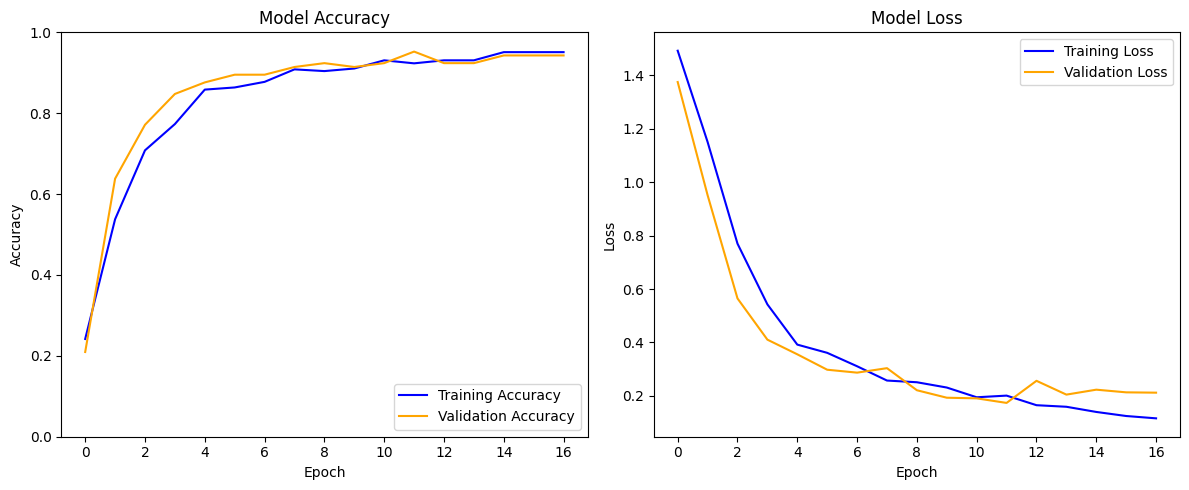

9/9 - 0s - 26ms/step - accuracy: 0.9466 - loss: 0.1554


INFO:__main__:Test accuracy: 0.9465649127960205
INFO:__main__:
Evaluating the model
INFO:__main__:Classification Report


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
              precision    recall  f1-score   support

      ticked       0.90      0.99      0.94        67
    unticked       1.00      0.88      0.93        72
 circled_yes       0.91      0.98      0.95        64
  circled_no       0.98      0.95      0.97        59

    accuracy                           0.95       262
   macro avg       0.95      0.95      0.95       262
weighted avg       0.95      0.95      0.95       262



In [76]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.metrics import classification_report
import logging
import random

# Set the random seeds for reproducibility
os.environ['PYTHONHASHSEED'] = '0'
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)
os.environ['TF_DETERMINISTIC_OPS'] = '1'

# Initialize logger
logging.basicConfig(level=logging.INFO)
LOGGER = logging.getLogger(__name__)

# Load and preprocess images
def load_images_from_folder(folder):
    current_dir = os.getcwd()
    folder_path = os.path.join(current_dir, folder)
    LOGGER.info(f"Folder path is {folder_path}")
    images = []
    labels = []
    
    if not os.path.isdir(folder_path):
        raise ValueError(f"Folder {folder_path} does not exist.")
    
    for label in os.listdir(folder_path):
        LOGGER.info(f"Processing label: {label}")
        if label == "images_test":
            continue
        label_folder = os.path.join(folder_path, label)
        LOGGER.info(f"Label '{label}' folder is {label_folder}")
        if not os.path.isdir(label_folder):
            continue
        # Walk through the label folder and its subfolders
        for root, dirs, files in os.walk(label_folder):
            for file in files:
                img_path = os.path.join(root, file)
                # LOGGER.info(f"Processing image {img_path}")
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Load image in grayscale
                if img is not None:
                    img = cv2.resize(img, (80, 140))  # Resize to 80x140 (width x height) for the model
                    images.append(img)
                    labels.append(label)
                else:
                    LOGGER.warning(f"Failed to load image {img_path}")
        # Removed the 'break' statement to allow processing all labels

    return np.array(images), np.array(labels)


# Load data
LOGGER.info("Loading images from dataset")
image_data, labels = load_images_from_folder('dataset/')
image_data = image_data.reshape(-1, 140, 80, 1)  # Add channel dimension for grayscale
image_data = image_data / 255.0  # Normalize the pixel values

# Convert labels to integers (e.g., ticked=0, unticked=1, circled_yes=2, circled_no=3)
LOGGER.info("Labeling images")
label_mapping = {'ticked': 0, 'unticked': 1, 'circled_yes': 2, 'circled_no': 3}
labels = np.array([label_mapping[label] for label in labels])

# Count the number of images per label
unique_labels, counts = np.unique(labels, return_counts=True)
label_names = {v: k for k, v in label_mapping.items()}  # Reverse mapping
print("\nNumber of images per label in the entire dataset:")
for label_int, count in zip(unique_labels, counts):
    label_name = label_names[label_int]
    print(f"{label_name} ({label_int}): {count} images")

# Split data into training, validation, and testing
LOGGER.info("Splitting data into training, validation, and testing")
X_train_full, X_test, y_train_full, y_test = train_test_split(
    image_data, labels, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=0.1, random_state=42)  # 10% of training data for validation

# Function to count labels
def count_labels(y, dataset_name):
    unique_labels, counts = np.unique(y, return_counts=True)
    print(f"\nNumber of images per label in the {dataset_name} set:")
    for label_int, count in zip(unique_labels, counts):
        label_name = label_names[label_int]
        print(f"{label_name} ({label_int}): {count} images")

# Count labels in each dataset
count_labels(y_train, "training")
count_labels(y_val, "validation")
count_labels(y_test, "testing")

# Compute class weights
class_weights_array = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train)
class_weights = dict(enumerate(class_weights_array))

# Create the CNN model
LOGGER.info("Creating CNN model with dropout")
model = models.Sequential()

# First convolutional block
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(140, 80, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.25))  # Dropout layer added

# Second convolutional block
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.25))  # Dropout layer added

# Third convolutional block
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
# Optional pooling layer if needed
# model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.25))  # Dropout layer added

# Flatten and dense layers
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.5))  # Dropout layer added
model.add(layers.Dense(4, activation='softmax'))

optimizer = Adam(learning_rate=0.001)

lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3)

# Compile the model
LOGGER.info("Compiling the model")
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
LOGGER.info("Training the model")
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(
    X_train, y_train,
    epochs=100,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping, lr_scheduler],
    class_weight=class_weights)


print("")
print("")
print("")
print("")
print("")



# Plot training and validation accuracy and loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy', color='blue')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.title('Model Loss')

plt.tight_layout()
plt.show()

# Evaluate the model on test data
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
LOGGER.info(f'Test accuracy: {test_acc}')



# Evaluate the model
LOGGER.info("\nEvaluating the model")
LOGGER.info("Classification Report")
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
print(classification_report(y_test, y_pred, target_names=label_mapping.keys()))


### function that wrangles images

In [73]:
import os
import random  # New import for randomness
from PIL import Image
import matplotlib.pyplot as plt

def process_images(folder_path, prefix, new_resolution=None, new_size=None, plot_images=False, seed=None, max_counter=None):
    # Collect image filenames
    image_filenames = [
        filename for filename in os.listdir(folder_path)
        if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.tiff', '.bmp', '.gif'))
    ]

    # Introduce randomness with a seed
    if seed is not None:
        random.seed(seed)
        random.shuffle(image_filenames)

    counter = 1
    output_folder = os.path.join(folder_path, 'processed_images')
    os.makedirs(output_folder, exist_ok=True)
    print(f"current counter is {counter}")
    for filename in image_filenames:
        # Stop processing if max_counter is reached
        if max_counter is not None and counter > max_counter:
            print(f"reached max counter {max_counter}")
            break
        
        original_file_path = os.path.join(folder_path, filename)
        try:
            with Image.open(original_file_path) as img:
                # Get image info
                dpi = img.info.get('dpi', (72, 72))  # Default DPI is (72, 72) if not specified
                width, height = img.size
                file_size = os.path.getsize(original_file_path)
                print(f"Counter: {counter}")
                print(f"Name: {filename}")
                print(f"Resolution (DPI): {dpi}")
                print(f"Dimensions: {width}x{height}")
                print(f"File size: {file_size} bytes\n")

                # Generate new filename
                file_extension = os.path.splitext(filename)[1]
                new_filename = f"{prefix}{counter}{file_extension}"
                new_file_path = os.path.join(output_folder, new_filename)

                # Avoid filename collisions
                while os.path.exists(new_file_path):
                    counter += 1
                    new_filename = f"{prefix}{counter}{file_extension}"
                    new_file_path = os.path.join(output_folder, new_filename)

                # Optionally resize the image
                img_for_saving = img
                if new_size:
                    img_for_saving = img.resize(new_size, Image.LANCZOS)

                # Save image with new DPI and/or size
                save_kwargs = {}
                if new_resolution:
                    save_kwargs['dpi'] = new_resolution
                img_for_saving.save(new_file_path, **save_kwargs)

                # If plotting is enabled, display the original and new images side by side
                if plot_images:
                    with Image.open(new_file_path) as new_img:
                        original_img_plot = img.convert('RGB')
                        new_img_plot = new_img.convert('RGB')

                        fig, axes = plt.subplots(1, 2, figsize=(12, 6))
                        axes[0].imshow(original_img_plot)
                        axes[0].set_title('Original Image')
                        axes[0].axis('off')

                        axes[1].imshow(new_img_plot)
                        axes[1].set_title('New Image')
                        axes[1].axis('off')

                        plt.show()

                counter += 1

        except Exception as e:
            print(f"Error processing {filename}: {e}")
    
    
# Usage
# folder_path = 'dataset/circled_yes'  # Replace with the path to your folder containing images
folder_path = 'dataset/circled_no'  # Replace with the path to your folder containing images
# folder_path = 'dataset/ticked'  # Replace with the path to your folder containing images
# folder_path = 'dataset/unticked'  # Replace with the path to your folder containing images
# prefix = 'not_circled_'                     # Replace with your desired prefix
# prefix = 'ticked_'                     # Replace with your desired prefix
prefix = 'not_circled_'                     # Replace with your desired prefix
# prefix = 'circled_'                     # Replace with your desired prefix
# new_resolution = (300, 300)           # Desired DPI, or None to keep original

# new_size = (120, 80)                 # New size in pixels (width, height), or None to keep original size
# new_size = (100, 60)                 # New size in pixels (width, height), or None to keep original size
# new_size = (60, 100)                 # New size in pixels (width, height), or None to keep original size
new_size = (80, 80)                 # New size in pixels (width, height), or None to keep original size
# new_size = (60, 60)                 # New size in pixels (width, height), or None to keep original size
plot_images = False                    # Set to True to plot images side by side
seed = 42                             # Set to an integer value for reproducibility
max_counter = 80                  # Process only up to this number of images

# process_images(folder_path, prefix, new_resolution, new_size, plot_images, seed, max_counter)

process_images(folder_path, prefix, new_size=new_size, plot_images=plot_images,seed=seed,max_counter=max_counter)



current counter is 1
Counter: 1
Name: no4 2.PNG
Resolution (DPI): (72, 72)
Dimensions: 131x77
File size: 455 bytes

Counter: 2
Name: no1_10.PNG
Resolution (DPI): (72, 72)
Dimensions: 134x75
File size: 3586 bytes

Counter: 3
Name: no7.PNG
Resolution (DPI): (72, 72)
Dimensions: 130x75
File size: 501 bytes

Counter: 4
Name: no1_6.PNG
Resolution (DPI): (72, 72)
Dimensions: 130x71
File size: 1209 bytes

Counter: 5
Name: no6.PNG
Resolution (DPI): (72, 72)
Dimensions: 131x76
File size: 504 bytes

Counter: 6
Name: no2 7.PNG
Resolution (DPI): (72, 72)
Dimensions: 137x76
File size: 1557 bytes

Counter: 7
Name: no1_21.PNG
Resolution (DPI): (72, 72)
Dimensions: 132x76
File size: 4685 bytes

Counter: 8
Name: no1_24.PNG
Resolution (DPI): (72, 72)
Dimensions: 135x70
File size: 1502 bytes

Counter: 9
Name: no1_26.PNG
Resolution (DPI): (72, 72)
Dimensions: 132x76
File size: 4685 bytes

Counter: 10
Name: no1_91.PNG
Resolution (DPI): (72, 72)
Dimensions: 128x75
File size: 551 bytes

Counter: 11
Name: yes

## attempt to train the model using image augemntation

INFO:__main__:Loading images from dataset
INFO:__main__:Folder path is /Users/brunoviola/WORK/detect_yes_no_answers/dataset/
INFO:__main__:Processing label: .DS_Store
INFO:__main__:Processing label: ticked
INFO:__main__:Processing label: circled_yes
INFO:__main__:Processing label: images_test
INFO:__main__:Processing label: circled_no
INFO:__main__:Processing label: unticked
INFO:__main__:Labeling images
INFO:__main__:Splitting data into training, validation, and testing
INFO:__main__:Compiling the model
INFO:__main__:Training the model


Class Distribution: {0: 244, 1: 342, 2: 108, 3: 140}
Class Weights: {0: 0.8571428571428571, 1: 0.6072874493927125, 2: 1.948051948051948, 3: 1.4851485148514851}
Epoch 1/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 90ms/step - accuracy: 0.2551 - loss: 2.0773 - val_accuracy: 0.1493 - val_loss: 1.5313 - learning_rate: 1.0000e-04
Epoch 2/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step - accuracy: 0.2972 - loss: 1.9993 - val_accuracy: 0.1343 - val_loss: 1.6253 - learning_rate: 1.0000e-04
Epoch 3/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - accuracy: 0.2753 - loss: 1.8999 - val_accuracy: 0.2090 - val_loss: 1.7767 - learning_rate: 1.0000e-04
Epoch 4/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 98ms/step - accuracy: 0.2854 - loss: 1.8981 - val_accuracy: 0.1940 - val_loss: 1.9355 - learning_rate: 1.0000e-04
Epoch 5/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - accuracy: 0.2805 - loss: 1.8555 - val_accuracy: 0.1642 - val_loss: 2.1706 - learning_rate: 1.0000e-04
Epoch 6/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - accura

INFO:__main__:Evaluating the model on test data


6/6 - 0s - 14ms/step - accuracy: 0.1617 - loss: 1.5467


INFO:__main__:Test accuracy: 0.16167664527893066, loss: 1.546655297279358
INFO:__main__:Generating classification report


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
              precision    recall  f1-score   support

      ticked       1.00      0.04      0.08        49
    unticked       0.00      0.00      0.00        68
 circled_yes       0.14      1.00      0.24        22
  circled_no       1.00      0.11      0.19        28

    accuracy                           0.16       167
   macro avg       0.53      0.29      0.13       167
weighted avg       0.48      0.16      0.09       167



/Users/brunoviola/bruvio-tools/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/brunoviola/bruvio-tools/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/brunoviola/bruvio-tools/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

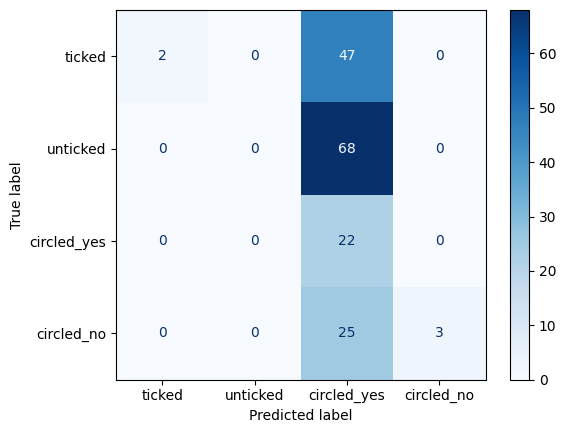

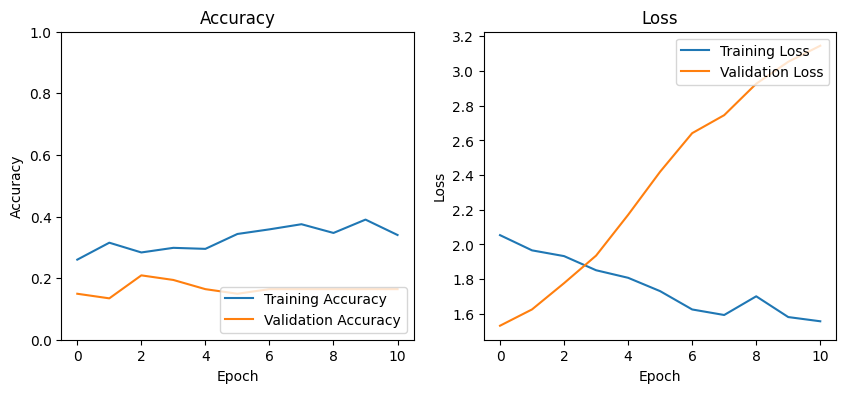

In [20]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import logging
import random

# Set the random seeds for reproducibility
os.environ['PYTHONHASHSEED'] = '0'
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)
os.environ['TF_DETERMINISTIC_OPS'] = '1'

# Initialize logger
logging.basicConfig(level=logging.INFO)
LOGGER = logging.getLogger(__name__)

# Load and preprocess images
def load_images_from_folder(folder):
    current_dir = os.getcwd()
    folder_path = os.path.join(current_dir, folder)
    LOGGER.info(f"Folder path is {folder_path}")
    images = []
    labels = []

    if not os.path.isdir(folder_path):
        raise ValueError(f"Folder {folder_path} does not exist.")

    for label in os.listdir(folder_path):
        LOGGER.info(f"Processing label: {label}")
        if label == "images_test" or label.startswith('.'):
            continue
        label_folder = os.path.join(folder_path, label)
        if not os.path.isdir(label_folder):
            continue

        for filename in os.listdir(label_folder):
            img_path = os.path.join(label_folder, filename)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Load image in grayscale
            if img is not None:
                img = cv2.resize(img, (80, 140))  # Resize to 80x140 (width x height) for the model
                # Apply histogram equalization
                img = cv2.equalizeHist(img)
                images.append(img)
                labels.append(label)

    return np.array(images), np.array(labels)

# Load data
LOGGER.info("Loading images from dataset")
image_data, labels = load_images_from_folder('dataset/')
image_data = image_data.astype('float32')
# Normalize the pixel values
image_data = image_data / 255.0

# Reshape the data
image_data = image_data.reshape(-1, 140, 80, 1)  # Add channel dimension for grayscale

# Convert labels to integers
LOGGER.info("Labeling images")
label_mapping = {'ticked': 0, 'unticked': 1, 'circled_yes': 2, 'circled_no': 3}
labels = np.array([label_mapping[label] for label in labels])

# Check class distribution
unique, counts = np.unique(labels, return_counts=True)
class_distribution = dict(zip(unique, counts))
print("Class Distribution:", class_distribution)

# Split data into training, validation, and testing with stratification
LOGGER.info("Splitting data into training, validation, and testing")
X_train_full, X_test, y_train_full, y_test = train_test_split(
    image_data, labels, test_size=0.2, random_state=42, stratify=labels)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=0.1, random_state=42, stratify=y_train_full)

# Recompute mean and std from training data only
mean = np.mean(X_train, axis=0)
std = np.std(X_train, axis=0)

# Standardize images
X_train = (X_train - mean) / (std + 1e-7)
X_val = (X_val - mean) / (std + 1e-7)
X_test = (X_test - mean) / (std + 1e-7)

# Compute class weights
class_weights_array = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train)
class_weights = dict(enumerate(class_weights_array))
print("Class Weights:", class_weights)

# Define data augmentation layers
data_augmentation = tf.keras.Sequential([
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomTranslation(0.1, 0.1),
    layers.RandomFlip("horizontal"),
])

# Simplify the model architecture and increase regularization
inputs = tf.keras.Input(shape=(140, 80, 1))
x = data_augmentation(inputs, training=True)

# First convolutional block
x = layers.Conv2D(16, (3, 3), activation='relu', kernel_regularizer=l2(1e-3))(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Dropout(0.5)(x)

# Second convolutional block
x = layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(1e-3))(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Dropout(0.5)(x)

# Flatten and dense layers
x = layers.Flatten()(x)
x = layers.Dense(16, activation='relu', kernel_regularizer=l2(1e-3))(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(4, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

# Adjust learning rate and optimizer
optimizer = tf.keras.optimizers.RMSprop(learning_rate=1e-4)

# Learning rate scheduler and early stopping
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Model checkpoint to save the best model
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True)

# Compile the model
LOGGER.info("Compiling the model")
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model with class weights
LOGGER.info("Training the model")
batch_size = 32
history = model.fit(
    X_train, y_train,
    batch_size=batch_size,
    epochs=100,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping, lr_scheduler, checkpoint],
    class_weight=class_weights,
)

# Evaluate the model on test data
LOGGER.info("Evaluating the model on test data")
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
LOGGER.info(f'Test accuracy: {test_acc}, loss: {test_loss}')

# Generate classification report
LOGGER.info("Generating classification report")
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
print(classification_report(y_test, y_pred, target_names=label_mapping.keys()))

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_mapping.keys())
disp.plot(cmap=plt.cm.Blues)
plt.show()

# Plot training and validation accuracy and loss
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history.get('val_accuracy'), label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history.get('val_loss'), label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.title('Loss')
plt.show()


Understanding the Classification Report

The classification report generated by sklearn.metrics.classification_report provides a detailed summary of the predictive performance of a classification model. It includes key metrics for each class in your dataset, helping you understand how well your model is performing, especially in cases of imbalanced datasets.
Metrics Included in the Classification Report

The report includes the following metrics for each class:

    Precision
    Recall
    F1-Score
    Support

These metrics provide insights into different aspects of your model's performance.
1. Precision

Definition:

    Precision is the ratio of correctly predicted positive observations to the total predicted positive observations.

Formula:
Precision=True Positives (TP)True Positives (TP)+False Positives (FP)
Precision=True Positives (TP)+False Positives (FP)True Positives (TP)​

Interpretation:

    Precision answers the question: "Of all instances that the model predicted as positive (e.g., a specific class), how many are actually positive?"
    A high precision indicates a low rate of false positives.

2. Recall (Sensitivity or True Positive Rate)

Definition:

    Recall is the ratio of correctly predicted positive observations to all actual positive observations.

Formula:
Recall=True Positives (TP)True Positives (TP)+False Negatives (FN)
Recall=True Positives (TP)+False Negatives (FN)True Positives (TP)​

Interpretation:

    Recall answers the question: "Of all actual positive instances, how many did the model correctly identify?"
    A high recall indicates a low rate of false negatives.

3. F1-Score

Definition:

    The F1-score is the harmonic mean of precision and recall. It combines both metrics into a single value.

Formula:
F1-Score=2×Precision×RecallPrecision+Recall
F1-Score=2×Precision+RecallPrecision×Recall​

Interpretation:

    F1-score balances the trade-off between precision and recall.
    It's useful when you need to seek a balance between precision and recall, especially with uneven class distribution.

4. Support

Definition:

    Support refers to the number of actual occurrences of each class in the dataset.

Interpretation:

    It shows how many samples of each class are present in the test dataset.
    Important for understanding the weight of each class in the overall performance metrics.

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 109ms/step


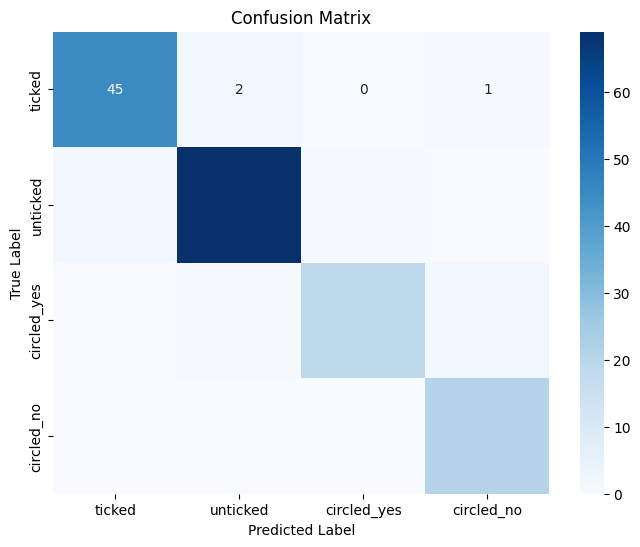

In [2]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Get the predicted probabilities
y_pred_probs = model.predict(X_test)

# Convert probabilities to class labels
y_pred = np.argmax(y_pred_probs, axis=1)

# Now compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Create ordered list of class names based on label_mapping
label_mapping = {'ticked': 0, 'unticked': 1, 'circled_yes': 2, 'circled_no': 3}
# Create a list of class names ordered by their label indices
class_names = [''] * len(label_mapping)
for class_name, index in label_mapping.items():
    class_names[index] = class_name

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


## saving the model

In [ ]:
# model.save('ticked_box_model.h5')
# model.save('ticked_box_model_new.keras')
# model.save('ticked_box_model_more_images.keras')

## load the model

In [ ]:


# Load the trained model globally so it's available in subsequent requests
# model = tf.keras.models.load_model('ticked_box_model_new.keras')
# model = tf.keras.models.load_model('ticked_box_model_more_images.keras')



## predict

In [9]:
import importlib
import main
import os
importlib.reload(main)
from main import *

In [13]:
def list_files_in_folder(folder_path, ext=None):
    """
    Returns a list of file names in the given folder, optionally filtering by extension.
    
    Parameters:
        folder_path (str): The path to the folder.
        ext (str, optional): The file extension to filter by (e.g., 'png'). Defaults to None.
        
    Returns:
        list: A list of file names matching the extension.
    """
    try:
        # List all files in the directory
        files = [
            f for f in os.listdir(folder_path)
            if os.path.isfile(os.path.join(folder_path, f))
        ]
        
        if ext is not None:
            # Normalize the extension to lowercase
            ext = ext.lower()
            # Filter files by extension (case-insensitive)
            files = [
                f for f in files
                if os.path.splitext(f)[1].lower() == f'.{ext}'
            ]
        
        return files
    
    except FileNotFoundError:
        print(f"The folder '{folder_path}' does not exist.")
        return []
    except PermissionError:
        print(f"Permission denied to access '{folder_path}'.")
        return []

from io import BytesIO
folder_list = [
    "dataset/images_test",
    "dataset/circled_no",
    "dataset/circled_yes",
    "dataset/unticked",
    "dataset/ticked",
    
]
widths = []
heights = []
aspect_ratios = []
        
threshold = 0.6  
for folder in folder_list:
    image_paths = list_files_in_folder(folder,ext="PNG")

    LOGGER.info(folder)
    for file_name in image_paths:
        LOGGER.info("\n\n")
        full_file_path = os.path.join(folder, file_name)
        LOGGER.info(f"processing image {full_file_path}")
        filename = full_file_path.split("/")[-1]
        image_name = filename.split(".")[0]
        unique_strings = [
        "no1_93",
        "no1_86",
        "yes1_2",
        "no1_96",
        "no1_97",
        "yes1_79",
        "no1_27",
        "no1_2",
        "no4",
        "no1_71",
        "yes1_60",
        "no1_22"
    ]
        

        image = cv2.imread(full_file_path)
        h, w = image.shape[:2]
        widths.append(w)
        heights.append(h)
        aspect_ratios.append(w/h)

        if file_name  in unique_strings:

        # if name  in unique_strings or 1:
        # break   
            try:
                with open(full_file_path, "rb") as image_file:
                     image_bytes = BytesIO(image_file.read())
                    
                result_payload = process_image_with_model(image_bytes, threshold,model)
                # Build consent dictionary
                consent = build_consent(result_payload, threshold)
                
                # Read the image using OpenCV for annotation
                image = cv2.imread(full_file_path)

                if image is None:
                    LOGGER.error("Failed to read the image for annotation.")
                    
                
                # Prepare annotation parameters
                output_directory = 'results_model'
                file_name_prefix = os.path.splitext(os.path.basename(full_file_path))[0]  # Use the original file name as prefix
                
                # Annotate the image
                annotated_image_path = annotate_image(
                    image=image,
                    consent=consent,
                    output_path=output_directory,
                    file_name_prefix=file_name_prefix
                )
                

            
            except Exception as e:
                LOGGER.exception("An unexpected error occurred in the main workflow.")
                


INFO:main:dataset/images_test
INFO:main:


INFO:main:processing image dataset/images_test/no1_89.PNG
INFO:main:


INFO:main:processing image dataset/images_test/yes1_79.PNG
INFO:main:


INFO:main:processing image dataset/images_test/no1_75.PNG
INFO:main:


INFO:main:processing image dataset/images_test/no1_70.PNG
INFO:main:


INFO:main:processing image dataset/images_test/no1_64.PNG
INFO:main:


INFO:main:processing image dataset/images_test/yes1_43.PNG
INFO:main:


INFO:main:processing image dataset/images_test/yes1_80.PNG
INFO:main:


INFO:main:processing image dataset/images_test/no1_2.PNG
INFO:main:


INFO:main:processing image dataset/images_test/no1_65.PNG
INFO:main:


INFO:main:processing image dataset/images_test/no1_71.PNG
INFO:main:


INFO:main:processing image dataset/images_test/yes1_69.PNG
INFO:main:


INFO:main:processing image dataset/images_test/no1_66.PNG
INFO:main:


INFO:main:processing image dataset/images_test/yes1_26.PNG
INFO:main:


INFO:main:processing image dat

In [128]:
len(widths)

5

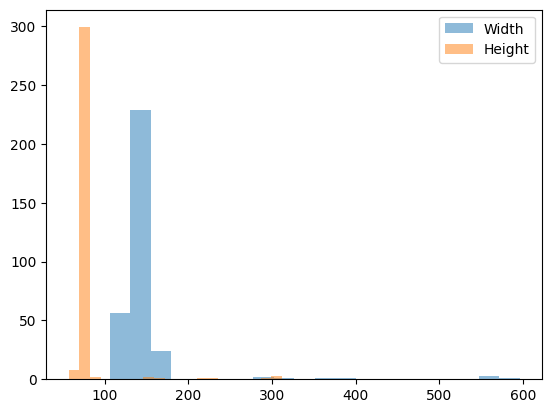

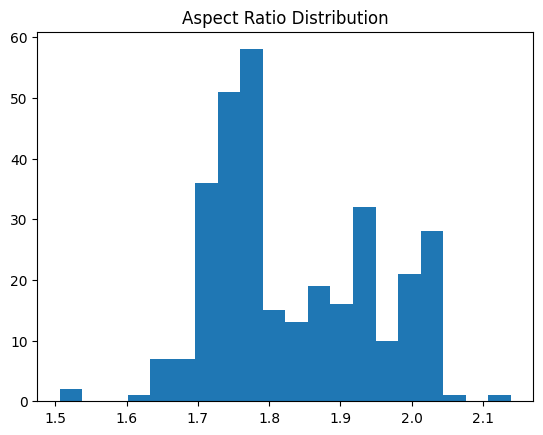

In [118]:
plt.hist(widths, bins=20, alpha=0.5, label='Width')
plt.hist(heights, bins=20, alpha=0.5, label='Height')
plt.legend()
plt.show()

plt.hist(aspect_ratios, bins=20)
plt.title('Aspect Ratio Distribution')
plt.show()